## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

1 [Подготовка](#1)

- [Просмотр данных](#1.1)

2 [Анализ](#2)

- [Ресемплирование](#2.1)
- [Изучение тренда, сезонности и остатока](#2.2)
- [Создадание признаков для горизонта прогнозирования](#2.3)
- [Разделение выборки](#2.4)

3 [Обучение](#3)

- [Метрика](#3.1)
- [Обучение и прогноз на тренировочных данных](#3.2)

4 [Тестирование](#4)

- [Константная модель](#4.1)
- [Прогноз по предыдущим значениям ряда](#4.2)
- [LinearRegression](#4.3)
- [DecisionTreeRegressor](#4.4)
- [RandomForestRegressor](#4.5)
- [XGBoost](#4.6)

5 [Итоги](#5)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt 

# 1. Подготовка<a id="1"></a>

Для того, чтобы корректно работать с датой и временем в pandas, нужно корректно изменить тип данных соответствующего столбца с object на datetime64. Один из вариантов — сделать это прямо при чтении с помощью параметра parse_dates. Также, необходимо установить индекс датафрейма, указав в параметре index_col список нужных столбцов:

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

### Просмотр данных<a id="1.1"></a>

In [3]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

print('=='*5, 'Info' , '=='*5)
display(data.info())
print('=='*5, 'missing data', '=='*5)
display(missing_data(data))
#print('=='*5, 'duplicated', '=='*5)
#display(data.duplicated().sum())
print('=='*5, 'describe', '=='*5)
display(data.describe())
print('=='*5, 'inspection', '=='*5)
display(data.head(10))

========== Info ==========
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

========== missing data ==========


,Total,Percent
num_orders,0,0.0


========== describe ==========


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


========== inspection ==========


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


# 2. Анализ<a id="2"></a>

Чтобы работать с временными рядами, необходимо проверить, в хронологическом ли порядке расположены даты и время. Для этого нужно посмотреть атрибут индекса таблицы is_monotonic*.* Если порядок соблюдён, атрибут вернёт True, если нет — False:

In [4]:
data.sort_index(inplace=True)

In [5]:
if data.index.is_monotonic:
    print('даты и время находятся в хронологическом порядке')
else:
    print('даты и время не имеют хронологии')

даты и время находятся в хронологическом порядке


Построим график временного ряда на выборке данных по дате, указав дату и время в качестве индекса за несколько дней:

<AxesSubplot:xlabel='datetime'>

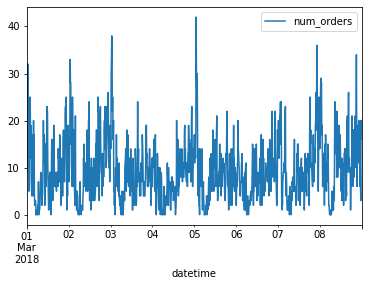

In [6]:
data['2018-03-01':'2018-03-08'].plot()

График не очень понятный. Произведем ресемплирование на 1 час с агрегирующей функцией *sum()*, для сложения вызовов за этот час

### Ресемплирование<a id="2.1"></a>

**Ресемплирование**, или **ресемплинг** (англ. *resample*) — это изменение интервала со значениями ряда. Его выполняют в два этапа:

1. Выбирают новую длину интервала. Причём значения из текущего интервала группируются.  
2. В каждой группе вычисляется агрегированное значение ряда. Это может быть медиана, среднее, максимум или минимум.

Чтобы поменять интервал и сгруппировать значения, вызовем функцию *resample()*, в аргументе укажем новый интервал:

<AxesSubplot:xlabel='datetime'>

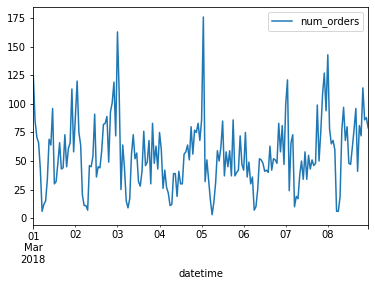

In [7]:
data = data.resample('1H').sum()

data['2018-03-01':'2018-03-08'].plot()

### Изучение тренда, сезонности и остатока<a id="2.2"></a>

*seasonal_decompose()* раскладывает временной ряд на три составляющие: тренд, сезонность и остаток

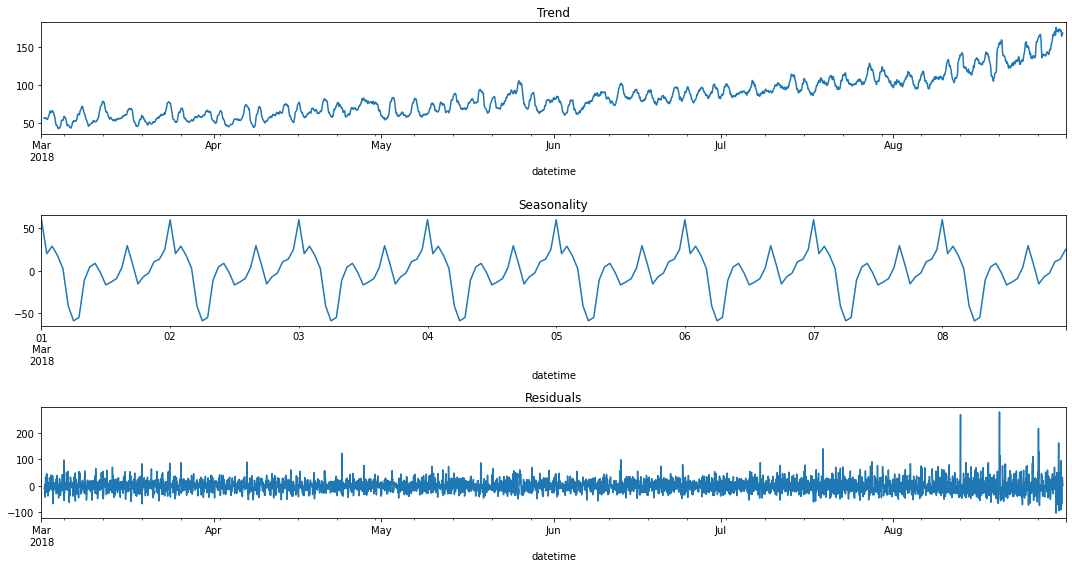

In [8]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis, получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-08'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Имеется тренд на увеличение и сезон периодом 1 сутки. Также имеется увеличенная дисперсия шума в конце временного ряда

### Создадание признаков для горизонта прогнозирования.<a id="2.3"></a>

Функция для создания признаков создает: 
- Календарные признаки
- Отстающие значения
- Скользящее среднее

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    # df['year'] = data.index.year
    df['month'] = data.index.month
    df['day'] = data.index.day
    df['dayofweek'] = data.index.dayofweek
    df['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    return df

In [10]:
data_work = make_features(data, 168, 24)
display(data_work.head())

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Разделение выборки<a id="2.4"></a>
Датасет разделяем на обучающую и тестовую выборки в соотношении 9:1. Из обучающей выборки удаляем строки с пропусками, образовавшимися при создании отстающих признаков и скользящего среднего.

feature_train, target_train (3806, 173) (3806,)
feature_test, target_test (442, 173) (442,)


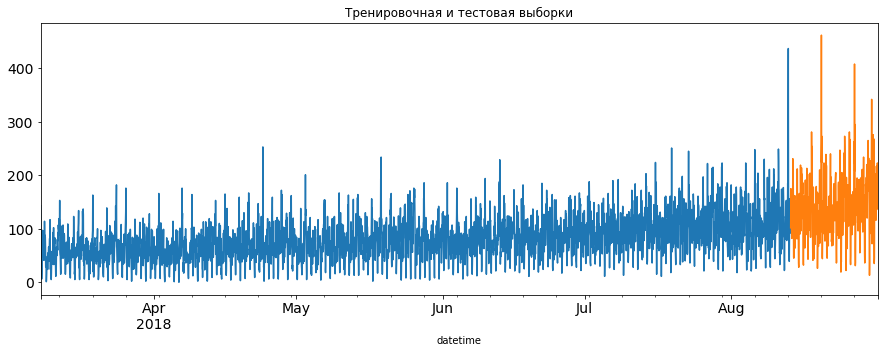

In [11]:
train, test = train_test_split(data_work, shuffle=False, test_size=0.1)
train = train.dropna()

feature_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']
feature_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

print('feature_train, target_train', feature_train.shape, target_train.shape)
print('feature_test, target_test', feature_test.shape, target_test.shape)


train['num_orders'].plot(figsize=(15,5), title= 'Тренировочная и тестовая выборки', fontsize=14)
test['num_orders'].plot()
plt.show()

# 3. Обучение<a id="3"></a>

### Метрика<a id="3.1"></a>

In [12]:
def RootMSE(target, predict): 
    return mean_squared_error(target, predict)**0.5

def plot_predict(target, predict):
    df_predict = pd.Series(predict, index=target.index, name='predict')
    for_plot = pd.concat([target, df_predict], axis=1)
    for_plot.plot(figsize=(16,4))
    plt.show()

def predict_test_RMSE(model, features, target, plot = True):
    predict = model.predict(features)
    if plot:
        plot_predict(target, predict)
    return round(RootMSE(target, predict), 2)

scorer = make_scorer(RootMSE)


### Обучение и прогноз на тренировочных данных<a id="3.2"></a>

In [13]:
lr = LinearRegression()
lr.fit(feature_train, target_train)
print("RMSE LinearRegression: ", predict_test_RMSE(lr, feature_train, target_train, plot = False))

RMSE LinearRegression:  20.33


In [14]:
tree_model = DecisionTreeRegressor(random_state=12345)
tree_model.fit(feature_train, target_train)
print("RMSE DecisionTreeRegressor: ", predict_test_RMSE(tree_model, feature_train, target_train, plot = False))

RMSE DecisionTreeRegressor:  0.0


In [15]:
param_search = {'max_depth' : [10, 20, 30],
                'n_estimators' : [40,60]   
               }

gs_forest = GridSearchCV(estimator = RandomForestRegressor(random_state=12345), 
                         cv = TimeSeriesSplit(n_splits=5),
                         param_grid=param_search,
                         n_jobs=-1,
                         scoring = scorer)

gs_forest.fit(feature_train, target_train)
print("RMSE RandomForestRegressor: ", predict_test_RMSE(gs_forest.best_estimator_, feature_train, target_train, plot = False))

RMSE RandomForestRegressor:  12.1


In [16]:
param_search = {'max_depth' : [3, 5, 8]}


gs_xgb = GridSearchCV(estimator = xgb.XGBRegressor(), 
                      cv=TimeSeriesSplit(n_splits=5),
                      n_jobs=-1,
                      param_grid=param_search)
gs_xgb.fit(feature_train, target_train)
print("RMSE xgboost: ", predict_test_RMSE(gs_xgb.best_estimator_, feature_train, target_train, plot = False))

RMSE xgboost:  13.48


# 4. Тестирование<a id="4"></a>

In [17]:
result = []

### Константная модель<a id="4.1"></a>

RMSE Константная модель медиана: 86.41465855206327


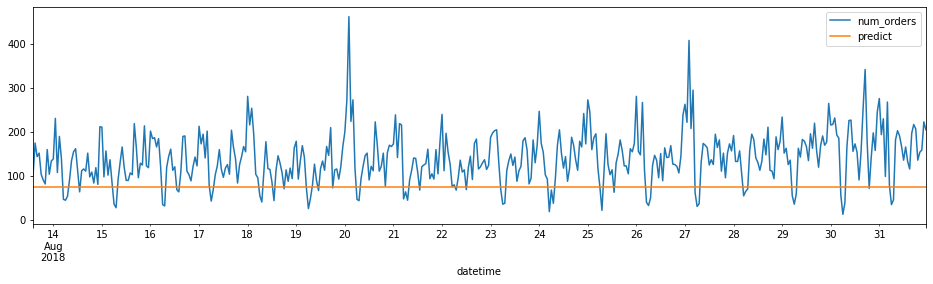

In [18]:
predict_median = np.ones(target_test.shape) * target_train.median()
result.append(['median', round(RootMSE(target_test, predict_median),2)])
print("RMSE Константная модель медиана:", RootMSE(target_test, predict_median))
plot_predict(target_test, predict_median)

### Прогноз по предыдущим значениям ряда<a id="4.2"></a>

RMSE по предыдущим значениям: 58.856486242815066


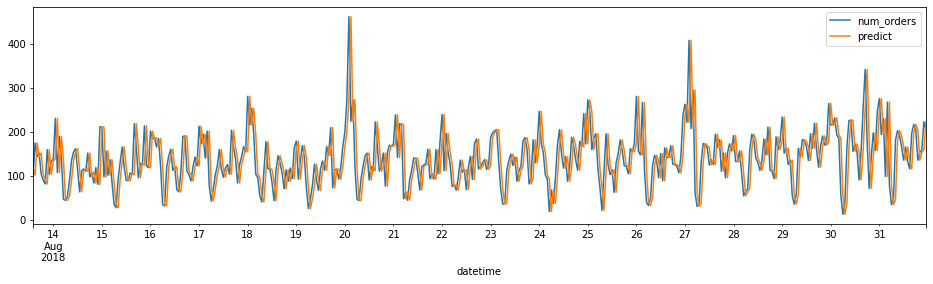

In [19]:
predict_previous = target_test.shift()
predict_previous.iloc[0] = target_train.iloc[-1]
result.append(['previous value forecasted', round(RootMSE(target_test, predict_previous), 2)])
print("RMSE по предыдущим значениям:", RootMSE(target_test, predict_previous))
plot_predict(target_test, predict_previous)

### LinearRegression<a id="4.3"></a>

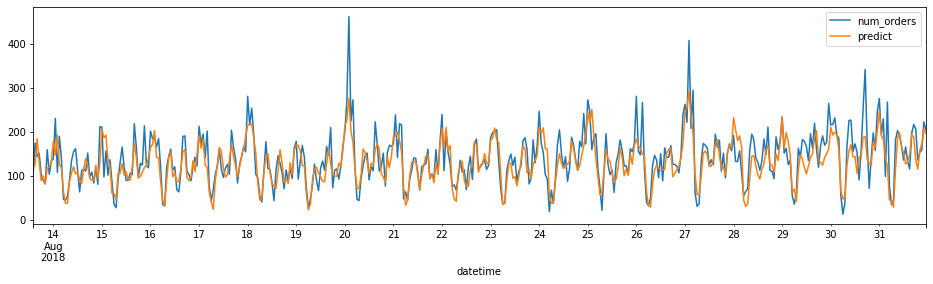

RMSE LinearRegression:  35.52


In [20]:
result.append(['LinearRegression', predict_test_RMSE(lr, feature_test, target_test, plot = False)])
print("RMSE LinearRegression: ", predict_test_RMSE(lr, feature_test, target_test, plot = True))

### DecisionTreeRegressor<a id="4.4"></a>

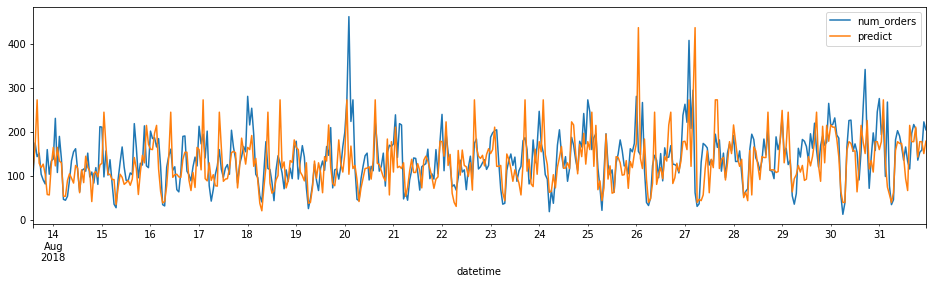

RMSE DecisionTreeRegressor:  57.31


In [21]:
result.append(['DecisionTreeRegressor', predict_test_RMSE(tree_model, feature_test, target_test, plot = False)])
print("RMSE DecisionTreeRegressor: ", predict_test_RMSE(tree_model, feature_test, target_test, plot = True))

### RandomForestRegressor<a id="4.5"></a>

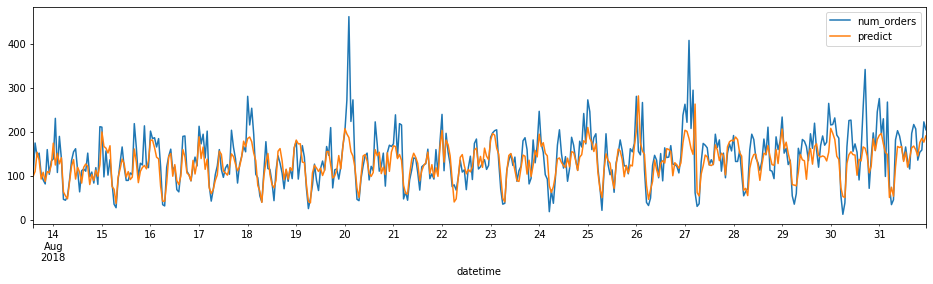

RMSE RandomForestRegressor:  40.58


In [22]:
result.append(['RandomForestRegressor', 
               predict_test_RMSE(gs_forest.best_estimator_, feature_test, target_test, plot = False)])
print("RMSE RandomForestRegressor: ", 
      predict_test_RMSE(gs_forest.best_estimator_, feature_test, target_test, plot = True))

### XGBoost<a id="4.6"></a>

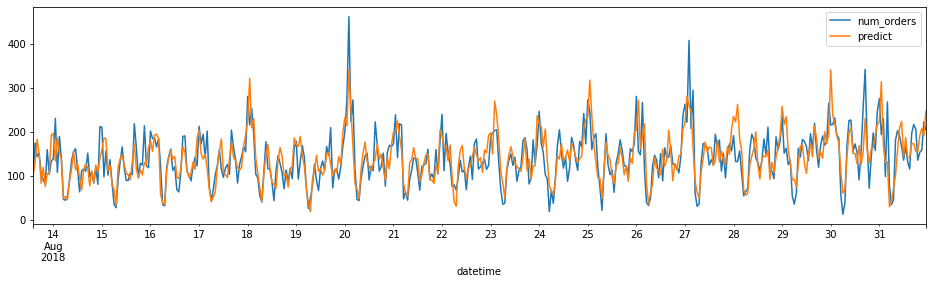

RMSE XGBoost:  40.03


In [23]:
result.append(['XGBoost', predict_test_RMSE(gs_xgb.best_estimator_, feature_test, target_test, plot = False)])
print("RMSE XGBoost: ", predict_test_RMSE(gs_xgb.best_estimator_, feature_test, target_test, plot = True))

## 5. Итоги<a id="5"></a>

In [24]:
def total_print(df):
    x = df['Model'] 
    y1 = df['RMSE']
    fig, ax = plt.subplots(1,1,figsize=(12,5))
    ax.bar( x, y1, width = 0.5)
    ax.set_title('Результаты обучения моделей', fontsize=20)
    ax.set_ylabel('RMSE', fontsize=16)
    plt.show()

In [25]:
result = pd.DataFrame(result, columns = ['Model', 'RMSE'])
display(result)

,Model,RMSE
0,median,86.41
1,previous value forecasted,58.86
2,LinearRegression,35.52
3,DecisionTreeRegressor,57.31
4,RandomForestRegressor,40.58
5,XGBoost,40.03


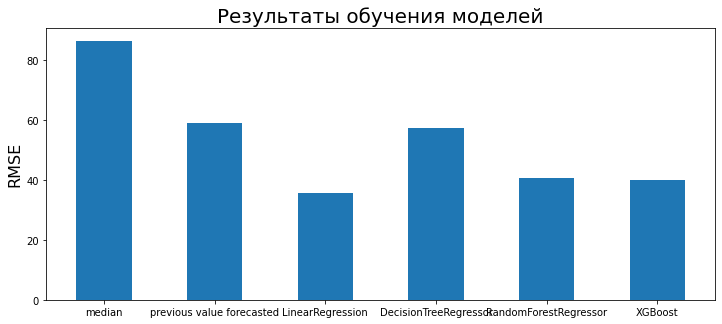

In [26]:
total_print(result)

Лучшие результаты показала модель RMSE XGBoost с показателем RMSE 40. Таким образом спрогнозировать количество заказов такси на следующий час модель сможет с RMSE 40. Медианное значение составляет 87 RMSE. Также XGBoost наиболее точно предсказывает пиковые значения.